In [38]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.integrate import quad
from scipy.linalg import solve
from typing import Callable
from matplotlib import pyplot as plt
import time
import pandas as pd

Рассматривается двухточечная краевая задача
$$
-pu'' + qu = f(x)\\
u(a) = 0, \quad u(b) = 0
$$

In [39]:
N: np.int64 = 10
K: np.int64 = 94

a: np.float64 = np.floor(np.pi*(N+10))
b: np.float64 = a + K/50 + 2

p: np.float64 = K*np.exp(10*N/K)
q: np.float64 = N*np.sin(np.power(K, N)) + 2*K

print(f'Границы отрезка: {a}, {b}')
print(f'Коэффициенты: {p}, {q}')

Границы отрезка: 62.0, 65.88
Коэффициенты: 272.35995884348756, 184.2541767404671


$\displaystyle u = -\cosh{\left(x-a-\frac{b-a}{2}\right)}+\cosh{\left(-\frac{b-a}{2} \right)} \implies \frac{du}{dx} = -\sinh{\left(x-a-\frac{b-a}{2}\right)} \implies \frac{d^2u}{dx^2} = -\cosh{\left(x-a-\frac{b-a}{2}\right)}$


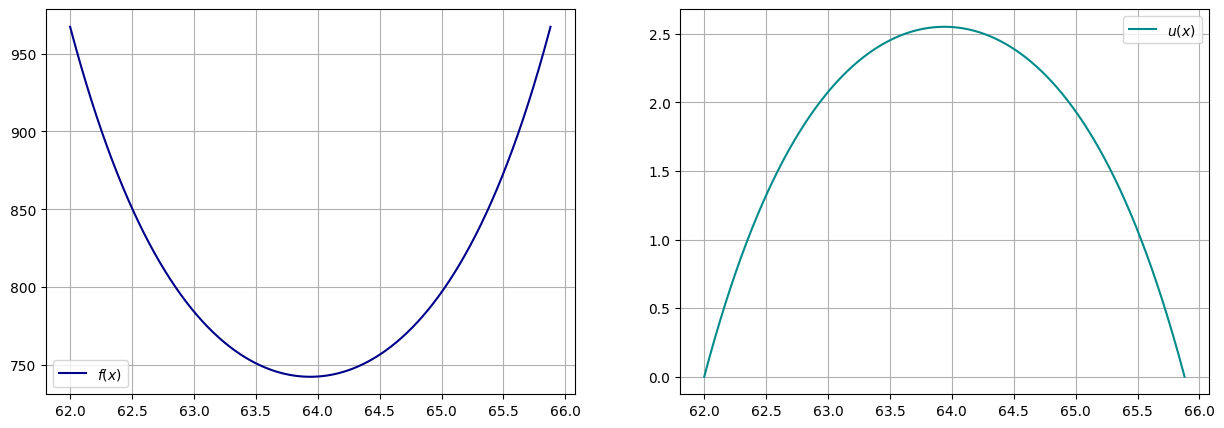

In [40]:
aver: np.float64 = a + (b-a)/2

u = lambda x: -np.cosh(x - aver) + np.cosh(a - aver)
du = lambda x: -np.sinh(x - aver)
ddu = lambda x: -np.cosh(x - aver)

f = lambda x: -p*ddu(x) + q*u(x)

func = np.array([f, u])
name = np.array(['$f$', '$u$'])
col = np.array(['darkblue', 'darkcyan'])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(a, b, 1000)

for i in range(axs.size):
    axs[i].plot(x, func[i](x), label=name[i]+'$(x)$', color=col[-i])
    axs[i].legend()
    axs[i].grid()

plt.show()

### 1. Составьте разностную схему МКЭ без явного создания матрицы $A$. Размерность системы $n = 4096, 2048, 1024, 512, 256$

In [41]:
nArr = np.array([np.power(2, i) for i in range(8, 13)], dtype=np.int64)[::-1]
hArr = (b-a)/nArr

def integr(f: Callable[[np.float64], np.float64], x1:np.float64, x2:np.float64)->np.float64:
    return quad(f, x1, x2)[0]

def vect(f: Callable[[np.float64], np.float64], n:np.float64)->np.ndarray:
    global a, b
    x, h = np.linspace(a, b, n+1, retstep=True)
    xf = lambda x: x*f(x)
    v = np.zeros(n-1)
    for i in range(1, n):
        v[i-1] = integr(xf, x[i-1], x[i]) - x[i-1]*integr(f, x[i-1], x[i]) + x[i+1]*integr(f, x[i], x[i+1]) - integr(xf, x[i], x[i+1])
    
    return 1*np.power(h, -2)*v

### 2.  Переделайте итерационный метод из ЛР 1 таким образом, чтобы он работал с оператором, реализующим матрично-векторное произведение, соответствующее методу и системе МКЭ.

In [ ]:
def operator(v:np.ndarray)->np.ndarray:
    global a, b, p, q
    h = (b-a)/v.size

    res1, res2 = np.zeros_like(v), np.zeros_like(v)
    res1[:] += 2*v
    res1[1:] -= v[:-1]
    res1[:-1] -= v[1:]

    res2[:] += 4*v
    res2[1:] += v[:-1]
    res2[:-1] += v[1:]

    return p/(h**2)*res1 + q/6*res2

def buildOperator(n:np.int64)->LinearOperator:
    return LinearOperator((n-1, n-1), operator)

def buildMatrix(A:LinearOperator)->np.ndarray:
    n = A.shape[0]
    return np.column_stack([A@np.eye(n)[:, i] for i in range(n)])

def CG(A:LinearOperator, b:np.ndarray, iter:np.int64)->np.ndarray:
    x = np.zeros(b.size)
    r = b - A(x)
    z = np.copy(r)

    for _ in range(iter):
        w = A(z)
        rsq = np.dot(r, r)
        a = rsq/np.dot(w, z)
        x = x + a*z
        r1 = r - a*w
        beta = np.dot(r1, r1)/rsq
        z = r1 + beta*z
        r = r1
      
    return x

$N\mod{3} + 1 = 2 \implies MGMW$

### 3. Реализуйте метод $MGMW$.

In [43]:
def cont(x:np.ndarray)->np.ndarray:
    xC = np.zeros(2*x.size - 1)
    xC[::2] = x
    xC[1::2] = 0.5*xC[:-2:2] + 0.5*xC[2::2]

    return xC

def proj(x:np.ndarray)->np.ndarray:
    xP = np.zeros(x.size//2 + 1)
    xP[1:-1] = 0.25*x[1:-2:2] + 0.5*x[2:-1:2] + 0.25*x[3::2]
    xP[0] = 0.75*x[0] + 0.25*x[1]
    xP[-1] = 0.75*x[-1] + 0.25*x[-2]

    return xP

def MGMW(k:np.int64, x:np.ndarray, b:np.ndarray, nu:np.int64)->np.ndarray:
    global A
    #print(A)
    if k == 0:
        x1 = solve(buildMatrix(buildOperator(nArr[-1])), vect(f, nArr[-1]))
        return x1
    else:
        xNu = CG(buildOperator(nArr[k]), vect(f, nArr[k]), nu)
        r = proj(vect(f, nArr[k]) - buildOperator(nArr[k])(xNu))
        e = np.zeros(nArr[k])
        for _ in range(1, 2):
            e1 = MGMW(k-1, e, r, nu)
            e = e1
        x1 = xNu + cont(e)
        return x1
    
def solver(k:np.int64, x:np.ndarray, nu:np.int64)->tuple[np.ndarray, np.float64]:
    global nArr
    eps: np.float64 = 10e-10
    n: np.int64 = x.size
    i = np.int64(np.where(nArr-1 == n)[0][0])

    start = time.time()
    while np.linalg.norm(vect(f, nArr[i]) - buildOperator(nArr[i])(x), ord=2) >= eps:
        x1 = MGMW(k, x, vect(f, nArr[k]), nu)
        x = x1
        i += 1
    end = time.time()

    return x, np.round(end-start, 5)

x, t = solver(1, np.ones(nArr[-1]-1), 10)

ValueError: operands could not be broadcast together with shapes (2047,) (509,) 

### 4. Заполните таблицу при каждом $n$

In [ ]:
nu = np.int64(np.linspace(10, 100, 10))
k = np.int64(np.linspace(1, 10, 10))

df = [pd.DataFrame(np.nan, index=k, columns=nu) for _ in range(nArr.size)]

for i in range(len(df)):
    for j in range(k.size):
        for m in range(nu.size):
            df[i].iloc[j, m] = solve(k[j], np.ones(nArr[i]), nu[m])[1]

ValueError: operands could not be broadcast together with shapes (4095,) (4096,) 

### $n = 256$

In [ ]:
df[0]

### $n=512$

In [ ]:
df[1]

### $n=1024$

In [ ]:
df[2]

### $n=2048$

In [ ]:
df[3]

### $n=4096$

In [ ]:
df[4]

### 5. Сравните с временем выполнения вашего итерационного метода.

### 6. Модифицируйте метод $MGMW$, добавив постсглаживание после коррекции с грубой сетки. Считая, что количество постсглаживающих итераций $\nu_{post}$ равно количеству предсглаживающих итераций $\nu_{pre}$ и $\nu_{post} + \nu_{pre} = \nu$, определите, как это повлияло на сходимость метода.